# Basics: Limb-darkened maps
In the previous tutorial, we talked about how to instantiate surface maps with arbitrary combinations of spherical harmonics. Here, we'll focus on a special case: the $m = 0$ spherical harmonics, which are all radially symmetric. As we show in [Luger & Agol (2018)](https://docs.google.com/viewer?url=https://github.com/rodluger/limbdark/raw/master-pdf/tex/limbdark.pdf), these form a complete basis to exactly describe arbitrary order polynomial limb-darkening in stars.

## The radial spherical harmonics

Here's what the first several radial spherical harmonics look like:

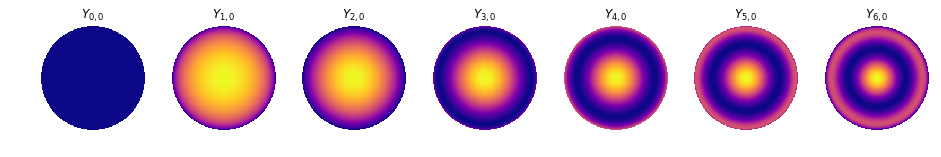

In [1]:
import starry
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

# Instantiate a regular `starry` surface map
lmax = 6
map = starry.Map(lmax)

res = 300
fig, ax = pl.subplots(1, lmax + 1, figsize=(16, 4))
x, y = np.meshgrid(np.linspace(-1, 1, res), np.linspace(-1, 1, res))
for l in range(lmax + 1):
    map.reset()
    map[l, 0] = 1
    I = [map.evaluate(x=x[j], y=y[j]) for j in range(res)]
    ax[l].imshow(I, origin="lower", interpolation="none", cmap='plasma', extent=(-1, 1, -1, 1))
    ax[l].axis('off')
    ax[l].set_title(r"$Y_{%d, 0}$" % l)
    ax[l].set_xlim(-1.05, 1.05)
    ax[l].set_ylim(-1.05, 1.05)

If we go out to infinite degree, we can express *any* radially symmetric function in terms of these harmonics. That makes this a very useful basis to model stellar limb darkening. In particular, consider the classic case of quadratic limb darkening, for which the specific intensity as a function of the radial coordinate $\mu$ (which is really just the Cartesian coordinate $z$) may be written

$\frac{I(\mu)}{I(1)} = 1 - u_1 (1 - \mu) - u_2 (1 - \mu)^2$

As we show in the paper, this can be written exactly as the sum of the first three radial spherical harmonics:

$\frac{I}{I(1)} =
            \frac{2\sqrt{\pi}}{3} (3 - 3u_1 - 4u_2) \, Y_{0,0}
          + \frac{2\sqrt{\pi}}{\sqrt{3}} (u_1 + 2u_2) \, Y_{1,0}
          - \frac{4\sqrt{\pi}}{3\sqrt{5}} u_2 \, Y_{2,0}$

For convenience, `starry` implements a special kind of map to deal with radially symmetric maps, `LimbDarkenedMap`. If your map is radially symmetric -- and in particular if you're doing linear or quadratic limb darkening -- you'll get a big performance boost when using a `LimbDarkenedMap`.

## The `LimbDarkenedMap` class

Instantiating a `LimbDarkenedMap` is similar to instantiating a `Map`:

In [2]:
map = starry.LimbDarkenedMap(2)
print(map)

<STARRY LimbDarkenedMap: u1 = 0.000, u2 = 0.000>


where the integer argument is (as before) the highest degree of the map. For quadratic limb darkening, 2 is what you want. Note that when we print the `map` object, we see that by default the two limb-darkening coefficients are set to zero, so our map has constant surface brightness: 

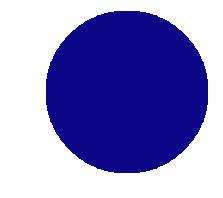

In [3]:
map.show()

Unlike the regular `Map` class, whose normalization depends on the coefficient of the $Y_{0,0}$ harmonic, a `LimbDarkenedMap` is always normalized so that the integral over the visible disk is unity. This makes it very convenient to use `LimbDarkenedMap`s to model stellar surfaces: regardless of the limb darkening coefficients, the total flux coming from the star will always be unity. We can check this by noting that the value everywhere on the surface is

In [4]:
map.evaluate(x=0, y=0)

array([0.31830989])

which, integrated over the unit disk is just

In [5]:
np.pi * map.evaluate(x=0, y=0)

array([1.])

You'll notice that a consequence of this is that the zeroth order limb-darkening coefficient $u_0$ **cannot** be set: its value is determined automatically to enforce this normalization.

Before we start playing around with this map, one last note: `LimbDarkenedMaps` cannot be rotated. It wouldn't really make sense for the limb darkening profile to rotate around with the star -- for instance, you'd end up with negative surface brightness if you rotated it by 180 degrees! There are, of course, cases where you'd like to rotate a star (if it has spots, for instance, and you're interested in its rotational light curve) but that's beyond the scope of this tutorial.

## Quadratic limb darkening

I remember reading somewhere that the Sun's quadratic limb darkening coefficients in the `Kepler` band are $u_1 = 0.40$ and $u_2 = 0.26$. Let's model that with `starry`:

In [6]:
map[1] = 0.4
map[2] = 0.26
print(map)

<STARRY LimbDarkenedMap: u1 = 0.400, u2 = 0.260>


Note that, unlike with the `Map` class, whose map is accessed by two indices (`l` and `m`), a `LimbDarkenedMap` is accessed by a **single** index `l` (since `m = 0` always). Here's what our map looks like:

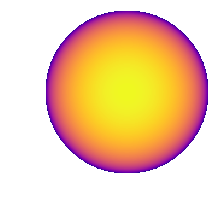

In [7]:
map.show()

We can verify, just for completeness, that we could have obtained the same exact map (up to a normalization constant) by setting the correct coefficients in the `Map` class:

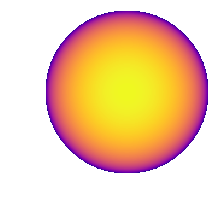

In [8]:
map2 = starry.Map(2)
u1 = 0.4
u2 = 0.26
map2[0, 0] = 2 * np.sqrt(np.pi) / 3 * (3 - 3 * u1 - 4 * u2)
map2[1, 0] = 2 * np.sqrt(np.pi) / np.sqrt(3) * (u1 + 2 * u2)
map2[2, 0] = -4 * np.sqrt(np.pi) / (3 * np.sqrt(5)) * u2
map.show()

But that's harder, messier, and slower to evaluate. Let's go back to our `LimbDarkenedMap` and compute some transit light curves.

## Transit light curves

These are super easy, and no different than in the `Map` case. Let's compute a simple transit light curve of a hot Jupiter:

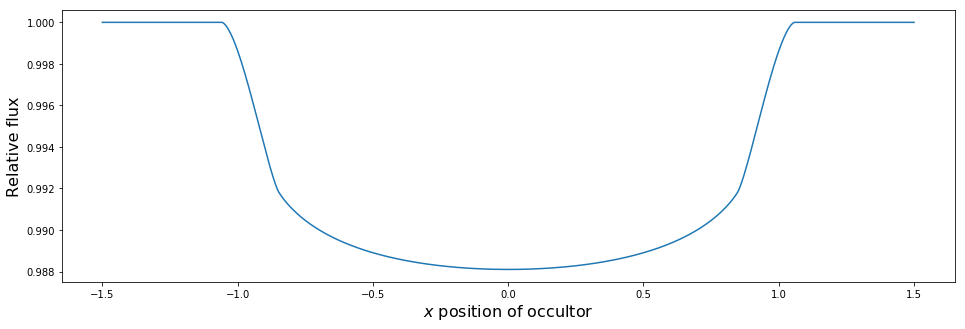

In [9]:
fig, ax = pl.subplots(1, figsize=(16, 5))
xo = np.linspace(-1.5, 1.5, 1000)
yo = 0.3
ro = 0.1
flux = map.flux(xo=xo, yo=yo, ro=ro)
ax.plot(xo, flux)
ax.set_xlabel('$x$ position of occultor', fontsize=16);
ax.set_ylabel('Relative flux', fontsize=16);

That's it for this tutorial. But check out the tutorial on higher order limb darkening for more!